In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import python classes and packages
from string import punctuation
#importing NLP packages for text review processing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
from nltk.stem import PorterStemmer
from keras.utils.np_utils import to_categorical
import os
from sklearn.metrics import accuracy_score
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, Model, load_model
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint 
from keras.layers import Bidirectional, GRU, LSTM, Conv1D, MaxPooling1D, RepeatVector#loading GRU, bidriectional, lstm and CNN
from sentence_transformers import SentenceTransformer #loading bert sentence model
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
#create bert model object
bert = SentenceTransformer('nli-distilroberta-base-v2')
print("Bert model initialized")

Bert model initialized


In [4]:
#defining classes to remove stop words, applying steeming and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [5]:
#define function to clean text reviews from dataset
def cleanText(doc):
    tokens = doc.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [ps.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = ' '.join(tokens)
    return tokens

In [6]:
#load and display Novelty Seeking reviews dataset
dataset = pd.read_csv("Dataset/processed.csv")
dataset

,content,label,type
0,Wow what an amazing walk on the Great Wall of ...,0,train
1,I came to spend 2 hours between 2 professional...,0,train
2,A MUST visit in one's life. History and Art fr...,1,train
3,"It's was very peaceful and beautiful, go with ...",0,train
4,It is beautiful lake in all seasons. Beautiful...,0,train
...,...,...,...
3995,I visited it right when the official change to...,0,valid
3996,Suomenlinna is stunning historic place. We wen...,1,valid
3997,"Milcha/Mike was funny, really knowledgeable an...",1,valid
3998,From the Helsinki market place there is a ferr...,1,valid


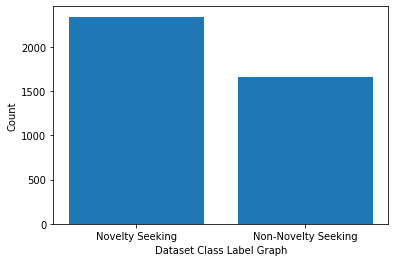

In [7]:
#find and plot graph of Novelty Seeking from dataset where 0 label refers as review contains Novelty Seeking and 1 as
#non-novelty seeking
#plot labels in dataset
labels, count = np.unique(dataset['label'], return_counts = True)
labels = ['Novelty Seeking', 'Non-Novelty Seeking']
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [8]:
#now clean dataset reviews and then convert to BERT vector
if os.path.exists("model/bert.npy"):
    X = np.load("model/bert.npy")
    Y = np.load("model/label.npy")
else:
    textdata = []
    labels = []
    for i in range(len(dataset)):#loop all reviews from dataset
        msg = dataset.get_value(i, 'content')#read review content
        label = dataset.get_value(i, 'label')#read label
        msg = msg.strip().lower()      #convert text to lower case  
        msg = cleanPost(msg)#clean the review message
        textdata.append(msg)#add message to textdata array    
        labels.append(label)#adding label to array
    embeddings = bert.encode(textdata, convert_to_tensor=True)#convert all text data into BERT vector
    X = embeddings.numpy()#convert bert vector into numpy for training
    np.save("model/bert", X)#save bert data and labels to model folder
    Y = np.asarray(labels)
    np.save("model/label", Y)
print("Bert Converted Embedding vector from dataset reviews")
print(X)

Bert Converted Embedding vector from dataset reviews
[[-0.04793587  0.5640375  -0.6450349  ... -0.65913534  0.9045596
   0.5499603 ]
 [ 0.70733136 -0.08709043  0.07673962 ... -0.32128632  0.6108363
   0.01826572]
 [-0.48672682  0.44718155 -0.50237244 ...  0.08478663  0.78687054
   0.23511195]
 ...
 [ 0.26772055  0.76312727 -0.02005892 ...  0.51458335  0.05910476
   0.42454597]
 [ 0.33064586  0.3962934   0.22244608 ... -0.4317711   0.66906726
   0.24422391]
 [ 0.8522946   0.74757236  0.3078637  ... -0.13496889  0.6102617
   0.81993985]]


In [9]:
#perform dataset preprocessing such as shuffling and splitting dataset into train and test where application used 80% dataset
#for training and 20% for testing
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X = np.reshape(X, (X.shape[0], 32, 24))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 3200
Testing Size (20%): 800



In [37]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

ML_Model = []
acc = []
prec = []
rec = []
f1 = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    acc.append(round(a, 3))
    prec.append(round(b, 3))
    rec.append(round(c, 3))
    f1.append(round(d, 3))

In [12]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# LSTM

In [13]:
#now train existing BERT-LSTM algorithm
lstm = Sequential() #defining deep learning sequential object
#adding GRU layer with 32 filters to filter given input X train data to select relevant features
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
#adding dropout layer to remove irrelevant features
lstm.add(Dropout(0.3))
#adding another layer
lstm.add(LSTM(32))
lstm.add(Dropout(0.3))
#defining output layer for prediction
lstm.add(Dense(y_train.shape[1], activation='softmax'))
#compile GRU model
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#if os.path.exists("model/lstm_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/lstm_weights.hdf5', verbose = 1, save_best_only = True)
hist = lstm.fit(X_train, y_train, batch_size = 16, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/lstm_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close() 
#else:
    #lstm = load_model("model/lstm_weights.hdf5")


Epoch 1/35
200/200 [==============================] - 17s 13ms/step - loss: 0.6794 - accuracy: 0.5781 - val_loss: 0.6456 - val_accuracy: 0.6425
Epoch 2/35
200/200 [==============================] - 2s 8ms/step - loss: 0.6499 - accuracy: 0.6243 - val_loss: 0.6220 - val_accuracy: 0.6525
Epoch 3/35
200/200 [==============================] - 2s 9ms/step - loss: 0.6133 - accuracy: 0.6626 - val_loss: 0.5971 - val_accuracy: 0.7063
Epoch 4/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5966 - accuracy: 0.6829 - val_loss: 0.5743 - val_accuracy: 0.7050
Epoch 5/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5584 - accuracy: 0.7219 - val_loss: 0.5737 - val_accuracy: 0.6862
Epoch 6/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5380 - accuracy: 0.7276 - val_loss: 0.5707 - val_accuracy: 0.7150
Epoch 7/35
200/200 [==============================] - 2s 8ms/step - loss: 0.5222 - accuracy: 0.7450 - val_loss: 0.5646 - val_accuracy: 0.7075
Epoc


Existing BERT-LSTM Model Accuracy  : 68.0
Existing BERT-LSTM Model Precision   : 67.03976414651243
Existing BERT-LSTM Model Recall      : 65.21789634677559
Existing BERT-LSTM Model FMeasure    : 65.4331989818997


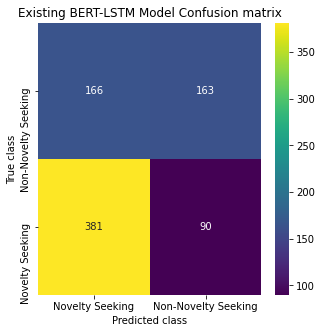

In [14]:
predict = lstm.predict(X_test)#perfrom prediction on test data
predict = np.argmax(predict, axis=1)
target = np.argmax(y_test, axis=1)
#calculate accuracy and other metrics
calculateMetrics("Existing BERT-LSTM Model", predict, target)

In [15]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')

In [38]:
storeResults('Existing BERT-LSTM Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# BiGRU

In [18]:
#now train propose BERT-BiGRU algorithm
gru_bilstm = Sequential() #defining deep learning sequential object
#adding GRU layer with 32 filters to filter given input X train data to select relevant features
gru_bilstm.add(Bidirectional(GRU(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
#adding dropout layer to remove irrelevant features
gru_bilstm.add(Dropout(0.3))
#adding another layer
gru_bilstm.add(Bidirectional(GRU(32)))#adding bidirectional-GRU layer and peform training on X_train Bert data
gru_bilstm.add(Dropout(0.3))
#defining output layer for prediction
gru_bilstm.add(Dense(y_train.shape[1], activation='softmax'))
#compile GRU model
gru_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#if os.path.exists("model/bigru_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/bigru_weights.hdf5', verbose = 1, save_best_only = True)
hist = gru_bilstm.fit(X_train, y_train, batch_size = 16, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/bigru_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close() 
#else:
    #gru_bilstm = load_model("model/bigru_weights.hdf5")


Epoch 1/35
200/200 [==============================] - 13s 15ms/step - loss: 0.6659 - accuracy: 0.5801 - val_loss: 0.6187 - val_accuracy: 0.6612
Epoch 2/35
200/200 [==============================] - 2s 9ms/step - loss: 0.6098 - accuracy: 0.6778 - val_loss: 0.5951 - val_accuracy: 0.6938
Epoch 3/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5978 - accuracy: 0.6673 - val_loss: 0.5758 - val_accuracy: 0.7125
Epoch 4/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5628 - accuracy: 0.7004 - val_loss: 0.5686 - val_accuracy: 0.7050
Epoch 5/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5524 - accuracy: 0.7182 - val_loss: 0.5819 - val_accuracy: 0.6888
Epoch 6/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5331 - accuracy: 0.7200 - val_loss: 0.5507 - val_accuracy: 0.7262
Epoch 7/35
200/200 [==============================] - 2s 9ms/step - loss: 0.5152 - accuracy: 0.7358 - val_loss: 0.5645 - val_accuracy: 0.7038
Epoc


Propose BERT-Bi-GRU Model Accuracy  : 99.59375
Propose BERT-Bi-GRU Model Precision   : 99.55607184911382
Propose BERT-Bi-GRU Model Recall      : 99.60895049224814
Propose BERT-Bi-GRU Model FMeasure    : 99.58224706691749


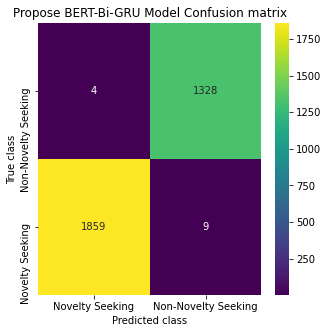

In [20]:
predict = gru_bilstm.predict(X_test)#perfrom prediction on test data
predict = np.argmax(predict, axis=1)
target = np.argmax(y_test, axis=1)
#calculate accuracy and other metrics
calculateMetrics("Propose BERT-Bi-GRU Model", predict, target)

In [22]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')

In [39]:
storeResults('Propose BERT-Bi-GRU Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# Extension BERT-CNN-Bi-GRU Model

In [23]:
#now define extension model by combining two different models called BERT + CNN + BiGRU models as this CNN + bi-lstm will 
#optimized features from both forward and backward direction so it will have more optimzied features and accuracy will be better
extension_model = Sequential()
#defining CNN layer
extension_model.add(Conv1D(filters=32, kernel_size = 15, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
extension_model.add(Conv1D(filters=16, kernel_size = 12, activation = 'relu'))
#adding maxpool layer
extension_model.add(MaxPooling1D(pool_size = 2))
extension_model.add(Dropout(0.3))
extension_model.add(Flatten())
extension_model.add(RepeatVector(2))
#adding bidirectional + GRU to CNN layer
extension_model.add(Bidirectional(GRU(24, activation = 'relu')))
extension_model.add(Dropout(0.3))
#defining output layer
extension_model.add(Dense(units = 33, activation = 'softmax'))
extension_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train the model
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#if os.path.exists("model/extension_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
hist = extension_model.fit(X_train, y_train, batch_size = 16, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/extension_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close()    
#else:
    #extension_model = load_model("model/extension_weights.hdf5")
#perform prediction on test data using bidirectional LSTM on test data   

Epoch 1/35
200/200 [==============================] - 10s 16ms/step - loss: 0.6786 - accuracy: 0.5729 - val_loss: 0.6335 - val_accuracy: 0.6650
Epoch 2/35
200/200 [==============================] - 3s 13ms/step - loss: 0.6335 - accuracy: 0.6635 - val_loss: 0.6073 - val_accuracy: 0.6925
Epoch 3/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5999 - accuracy: 0.6977 - val_loss: 0.6055 - val_accuracy: 0.6750
Epoch 4/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5609 - accuracy: 0.7376 - val_loss: 0.5881 - val_accuracy: 0.6938
Epoch 5/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5478 - accuracy: 0.7366 - val_loss: 0.6069 - val_accuracy: 0.6938
Epoch 6/35
200/200 [==============================] - 3s 13ms/step - loss: 0.5036 - accuracy: 0.7786 - val_loss: 0.6125 - val_accuracy: 0.6963
Epoch 7/35
200/200 [==============================] - 3s 13ms/step - loss: 0.4733 - accuracy: 0.8080 - val_loss: 0.5720 - val_accuracy: 0.721


Extension BERT-CNN-Bi-GRU Model Accuracy  : 97.46875
Extension BERT-CNN-Bi-GRU Model Precision   : 97.57700152952195
Extension BERT-CNN-Bi-GRU Model Recall      : 97.21796207342246
Extension BERT-CNN-Bi-GRU Model FMeasure    : 97.38610576046018


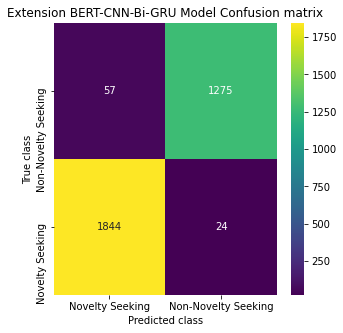

In [24]:
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
target = np.argmax(y_test, axis=1)
#calculate accuracy and other metrics
calculateMetrics("Extension BERT-CNN-Bi-GRU Model", predict, target)

In [25]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')



In [40]:
storeResults('Extension BERT-CNN-Bi-GRU Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# LSTM + GRU

In [26]:
#now train propose BERT-BiGRU algorithm
lstmgru = Sequential() #defining deep learning sequential object
#adding GRU layer with 32 filters to filter given input X train data to select relevant features
lstmgru.add(Bidirectional(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
#adding dropout layer to remove irrelevant features
lstmgru.add(Dropout(0.3))
#adding another layer
lstmgru.add(Bidirectional(GRU(32)))#adding bidirectional-GRU layer and peform training on X_train Bert data
lstmgru.add(Dropout(0.3))
#defining output layer for prediction
lstmgru.add(Dense(y_train.shape[1], activation='softmax'))
#compile GRU model
lstmgru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#if os.path.exists("model/bigru_weights.hdf5") == False:
    #model_check_point = ModelCheckpoint(filepath='model/bigru_weights.hdf5', verbose = 1, save_best_only = True)
hist = lstmgru.fit(X_train, y_train, batch_size = 2, epochs = 35, validation_data=(X_test, y_test), verbose=1)
    #f = open('model/bigru_history.pckl', 'wb')
    #pickle.dump(hist.history, f)
    #f.close() 
#else:
    #gru_bilstm = load_model("model/bigru_weights.hdf5")


Epoch 1/35
1600/1600 [==============================] - 19s 9ms/step - loss: 0.6614 - accuracy: 0.6029 - val_loss: 0.6004 - val_accuracy: 0.6862
Epoch 2/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5890 - accuracy: 0.6834 - val_loss: 0.5980 - val_accuracy: 0.6850
Epoch 3/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5583 - accuracy: 0.7158 - val_loss: 0.5555 - val_accuracy: 0.7250
Epoch 4/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5329 - accuracy: 0.7330 - val_loss: 0.5514 - val_accuracy: 0.7250
Epoch 5/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.5223 - accuracy: 0.7384 - val_loss: 0.5530 - val_accuracy: 0.7212
Epoch 6/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.4780 - accuracy: 0.7762 - val_loss: 0.5471 - val_accuracy: 0.7225
Epoch 7/35
1600/1600 [==============================] - 13s 8ms/step - loss: 0.4457 - accuracy: 0.7942 - val_loss: 0.5479 - val_ac


Extension BERT-LSTM-GRU Model Accuracy  : 99.375
Extension BERT-LSTM-GRU Model Precision   : 99.38919661124446
Extension BERT-LSTM-GRU Model Recall      : 99.32464584498845
Extension BERT-LSTM-GRU Model FMeasure    : 99.35654050436769


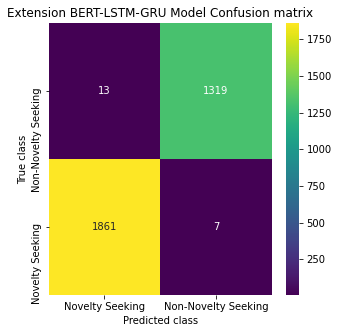

In [27]:
predict = lstmgru.predict(X_test)
predict = np.argmax(predict, axis=1)
target = np.argmax(y_test, axis=1)
#calculate accuracy and other metrics
calculateMetrics("Extension BERT-LSTM-GRU Model", predict, target)

In [41]:
blstm_acc = (accuracy_score(predict, target))
blstm_prec = precision_score(predict, target,average='weighted')
blstm_rec = recall_score(predict, target,average='weighted')
blstm_f1 = f1_score(predict, target,average='weighted')

storeResults('Extension BERT-LSTM-GRU Model',blstm_acc,blstm_prec,blstm_rec,blstm_f1)

# Comparison

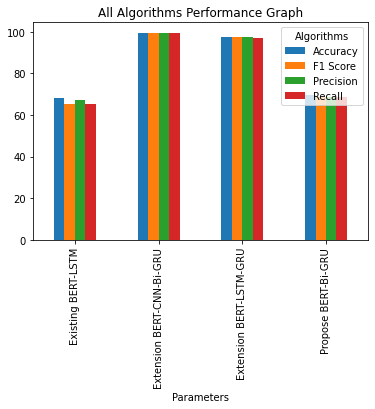

In [30]:
#all algorithms performance graph
df = pd.DataFrame([['Existing BERT-LSTM','Precision',precision[0]],['Existing BERT-LSTM','Recall',recall[0]],['Existing BERT-LSTM','F1 Score',fscore[0]],['Existing BERT-LSTM','Accuracy',accuracy[0]],
                   ['Propose BERT-Bi-GRU','Precision',precision[1]],['Propose BERT-Bi-GRU','Recall',recall[1]],['Propose BERT-Bi-GRU','F1 Score',fscore[1]],['Propose BERT-Bi-GRU','Accuracy',accuracy[1]],
                   ['Extension BERT-CNN-Bi-GRU','Precision',precision[2]],['Extension BERT-CNN-Bi-GRU','Recall',recall[2]],['Extension BERT-CNN-Bi-GRU','F1 Score',fscore[2]],['Extension BERT-CNN-Bi-GRU','Accuracy',accuracy[2]],
                   ['Extension BERT-LSTM-GRU','Precision',precision[3]],['Extension BERT-LSTM-GRU','Recall',recall[3]],['Extension BERT-LSTM-GRU','F1 Score',fscore[3]],['Extension BERT-LSTM-GRU','Accuracy',accuracy[3]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [42]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : acc,
                       'Precision': prec,
                       'Recall'   : rec,
                        'f1_score' : f1,
                      })

In [43]:
result

,ML Model,Accuracy,Precision,Recall,f1_score
0,Existing BERT-LSTM Model,0.994,0.994,0.994,0.994
1,Propose BERT-Bi-GRU Model,0.995,0.995,0.995,0.995
2,Extension BERT-CNN-Bi-GRU Model,0.975,0.975,0.975,0.975
3,Extension BERT-LSTM-GRU Model,0.994,0.994,0.994,0.994


In [35]:
lstmgru.save('model.h5')

In [46]:
classifier = ["Existing BERT-LSTM", "Propose BERT-Bi-GRU", "Extension BERT-CNN-Bi-GRU","Extension BERT-LSTM-GRU"]
y_pos = np.arange(len(classifier))

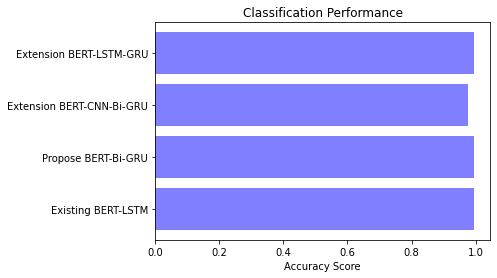

In [47]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, acc, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

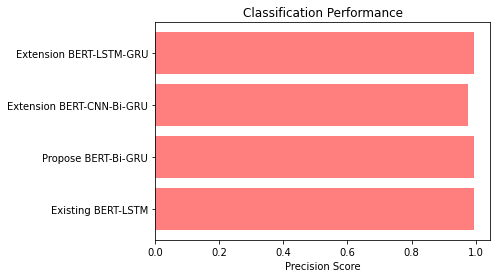

In [48]:
plt2.barh(y_pos, prec, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

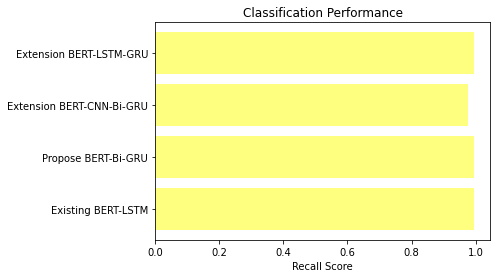

In [49]:
plt2.barh(y_pos, rec, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

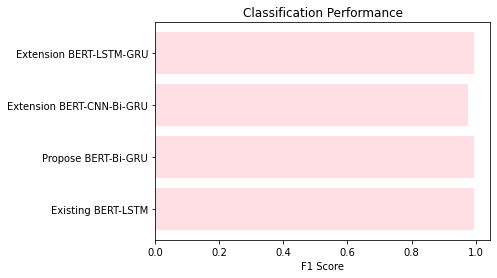

In [50]:
plt2.barh(y_pos, f1, align='center', alpha=0.5,color='pink')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

# Prediction

In [59]:
model = load_model('model.h5')

In [98]:
msg = 'Our hotel was near the shops and river hotel ibis strasbourg centre petite france we walked round very busy but pretty and looking at all the restaurants to have something to eat plenty of places and lots of choice .We went to steakhouse district and had steak meal and also '

In [99]:
#msg = dataset.get_value(i, 'content')#read test review as message
msgs = msg.strip().lower()        #convert to lower case
msgs = cleanText(msgs)#clean messages
data = []

In [100]:
data.append(msgs)#add message to array

In [101]:
embeddings = bert.encode(data, convert_to_tensor=True)#convert message review to bert vector

In [102]:
X = embeddings.numpy()#convert vector to numpy
X = np.reshape(X, (X.shape[0], 32, 24))#reshape vector

In [103]:
predict = model.predict(X)#using extension model predict weather test message is Novelty or not

In [104]:
predict = np.argmax(predict)

In [106]:
predict

1

In [105]:
labels[predict]

'Non-Novelty Seeking'